## Tokenizer

- Tokenizer, metni küçük anlamlı parçalara (tokenlara) ayırmaktır. 
- Bu parçalar genellikle kelime, kelime kökü, hece ya da karakter olabilir. 

##### Kelime Bazlı Tokenizer (Word-level)
- Metni boşluklara göre ayırır.
- Basit ama bilinmeyen kelimelerde (örneğin "merhabaa") başarısız olabilir.

##### Alt-Kelime Tokenizer (Subword-level)
- En yaygın olanıdır (örnek: BPE, WordPiece, SentencePiece).
- Kelimeleri parçalayarak bilinmeyen kelimeleri de işleyebilir.
- GPT, BERT gibi modeller bunu kullanır.

##### Karakter Bazlı Tokenizer (Character-level)
- Her bir karakteri token olarak alır.
- Çok esnektir ama genelde uzun sekanslar üretir.

In [ ]:
"""
anaconda üzerinde env oluşturmak için: conda create -n llm python=3.10 -y
oluşturulan env aktif hale getirmek için: conda activate llm
gerekli kütüphaneleri yüklemek için:
pip install tiktoken
pip install datasets
pip install transformers
pytorch için -> conda install pytorch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1  pytorch-cuda=11.8 -c pytorch -c nvidia 

"""

In [1]:
import torch
import tiktoken
import transformers
import datasets
import re

c:\Users\aliil\anaconda3\envs\llm_v1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text1 = "The mother woke the child."
text2 = "The child woke his mother."

In [3]:
# text1 ve text2 için basic bir tokenizer oluşturalım
def basic_tokenizer(text):
    return text.split()
print(basic_tokenizer(text1))
print(basic_tokenizer(text2))
#text1 ve text2 için token'lar "The, mother, woke, the, child. ve The, child, woke, his, mother." olacaktır.
#Gördüğünüz gibi basic tokenizer noktalama işaretlerini ayrı bir token olarak ele almıyor.
#Bunu düzeltmek için regex tabanlı bir tokenizer kullanabiliriz.

def regex_tokenizer(text):
    return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
print(regex_tokenizer(text1))
print(regex_tokenizer(text2))

['The', 'mother', 'woke', 'the', 'child.']
['The', 'child', 'woke', 'his', 'mother.']
['The', 'mother', 'woke', 'the', 'child', '.']
['The', 'child', 'woke', 'his', 'mother', '.']


In [4]:
# token'ların tutulduğu bir sözlük oluşturalım
vocab = {}
def build_vocab(tokenized_texts):
    for tokens in tokenized_texts:
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab) + 1  # 0'ı padding için ayırıyoruz
    return vocab
build_vocab([basic_tokenizer(text1), basic_tokenizer(text2)])
# print(build_vocab([basic_tokenizer(text1), basic_tokenizer(text2)]))
print(vocab)

{'The': 1, 'mother': 2, 'woke': 3, 'the': 4, 'child.': 5, 'child': 6, 'his': 7, 'mother.': 8}


In [5]:
# oluşabilecek bilinmeyen token'lar için vocab'a bir "</unk>" token'ı ekleyelim
vocab["</unk>"] = 0
print(vocab)

{'The': 1, 'mother': 2, 'woke': 3, 'the': 4, 'child.': 5, 'child': 6, 'his': 7, 'mother.': 8, '</unk>': 0}


In [6]:
# şimdi token'ları indekslere dönüştüren bir fonksiyon yazalım
def tokens_to_indices(text):
    if isinstance(text, list):
        return [[vocab.get(token, vocab["</unk>"]) for token in basic_tokenizer(t)] for t in text]
    else:
        return [vocab.get(token, vocab["</unk>"]) for token in basic_tokenizer(text)]
print(tokens_to_indices(text1))
print(tokens_to_indices(text2))
# cümleler aynı kelimelere sahip olsa bile indeksler farklı olacaktır çünkü kelimelerin sırası farklıdır.

[1, 2, 3, 4, 5]
[1, 6, 3, 7, 8]


In [7]:
def indices_to_text(indices):
    # index → token eşlemesi için ters sözlük
    inv_vocab = {v: k for k, v in vocab.items()}
    
    if isinstance(indices[0], list):  # Çoklu cümle (batch)
        return [" ".join([inv_vocab.get(idx, "</unk>") for idx in seq]) for seq in indices]
    else:
        return " ".join([inv_vocab.get(idx, "</unk>") for idx in indices])
print(indices_to_text(tokens_to_indices(text1)))
print(indices_to_text(tokens_to_indices(text2)))

The mother woke the child.
The child woke his mother.


In [8]:
# bu işlemlerde temel düzeyde bir tokenizer oluşturduk.
# encoding için token_to_indices, decoding için indices_to_text fonksiyonlarını yazdık.
# basic tokenizer ve regex_tokenizer ile tokenizasyon yaptık.
encoded1 = tokens_to_indices(text1)
encoded2 = tokens_to_indices(text2)

print("Encoded1:", encoded1)
print("Encoded2:", encoded2)

decoded1 = indices_to_text(encoded1)
decoded2 = indices_to_text(encoded2)

print("Decoded1:", decoded1)
print("Decoded2:", decoded2)

Encoded1: [1, 2, 3, 4, 5]
Encoded2: [1, 6, 3, 7, 8]
Decoded1: The mother woke the child.
Decoded2: The child woke his mother.


## Tiktokenizer

In [9]:
# tiktoken ve transformers kütüphanelerini kullanarak daha gelişmiş tokenizasyon işlemleri yapabiliriz.


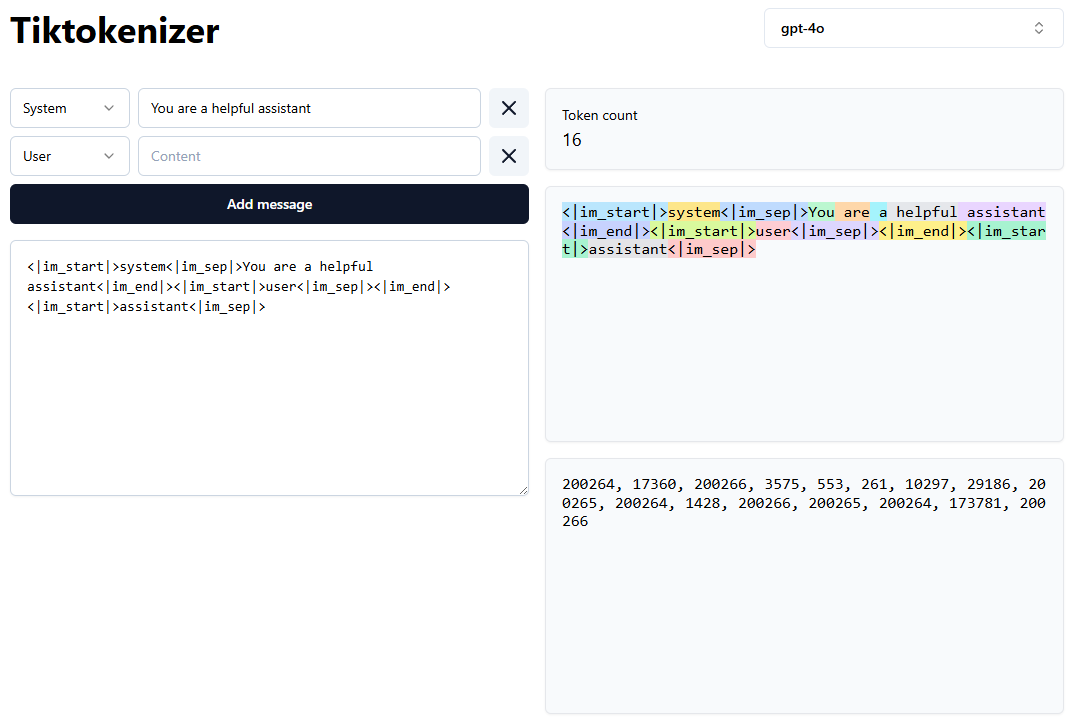

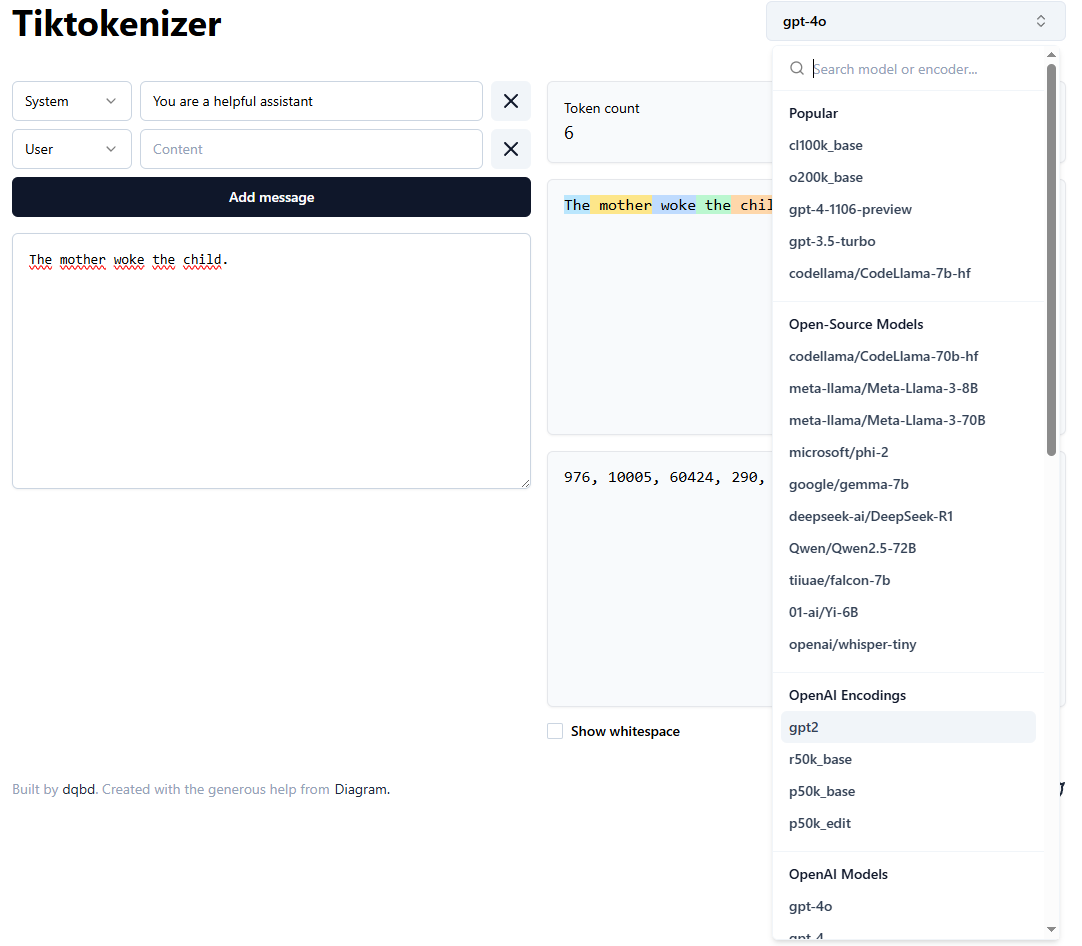

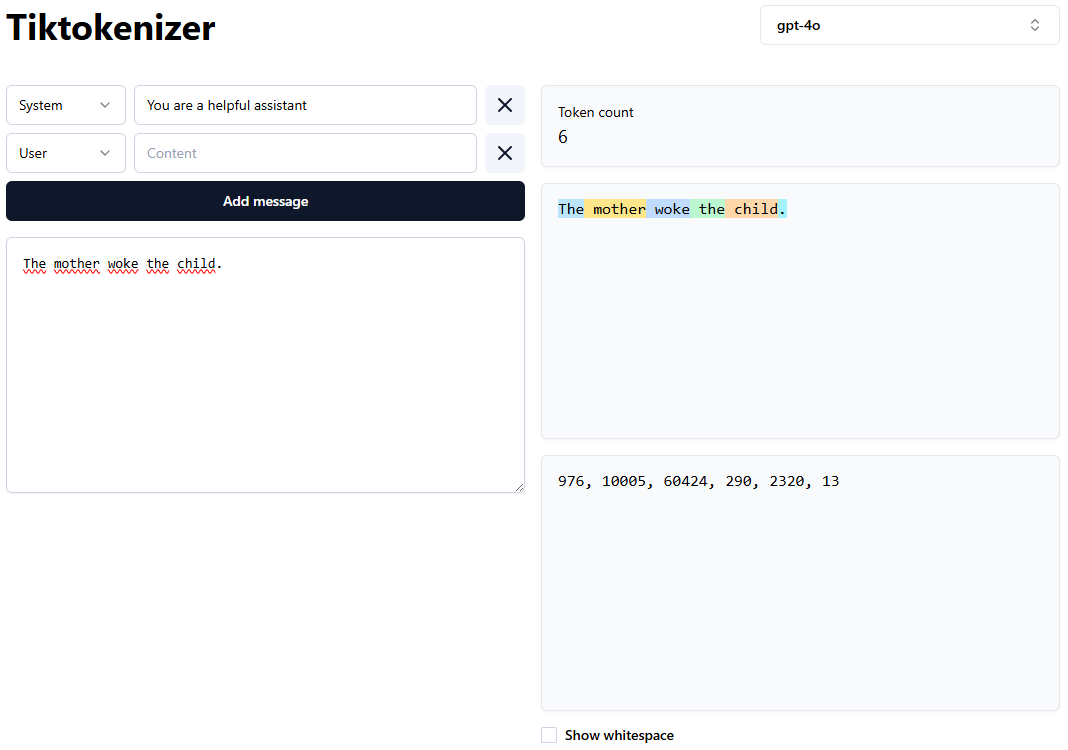

Görsellerde görültüğü gibi Tiktokenizer kütüphanesi ile farklı dil modellerindeki vocab kullanılarak cümlelerin ID'leri oluşturulabilir.

In [ ]:
import tiktoken
tiktoken_encoder_v1 = tiktoken.get_encoding("cl100k_base")  # OpenAI'nin GPT-3.5 ve GPT-4 modelleri için kullanılan encoding
tiktoken_encoder_v2 = tiktoken.get_encoding("gpt2")  # OpenAI'nin GPT-2 modeli için kullanılan encoding
print("Tiktoken V1 (cl100k_base) Token IDs:", tiktoken_encoder_v1.encode(text1))
print("Tiktoken V2 (gpt2) Token IDs:", tiktoken_encoder_v2.encode(text1))
#farklı modellerin farklı vocab'ları ve tokenizasyon stratejileri vardır.

Tiktoken V1 (cl100k_base) Token IDs: [791, 6691, 39826, 279, 1716, 13]
Tiktoken V2 (gpt2) Token IDs: [464, 2802, 19092, 262, 1200, 13]


In [11]:
# oluşturulan ID'lerin decoding ile tekrar metne dönüştürülmesi
print("Decoded from Tiktoken V1:", tiktoken_encoder_v1.decode(tiktoken_encoder_v1.encode(text1)))
print("Decoded from Tiktoken V2:", tiktoken_encoder_v2.decode(tiktoken_encoder_v2.encode(text1)))

Decoded from Tiktoken V1: The mother woke the child.
Decoded from Tiktoken V2: The mother woke the child.


In [12]:
# modellerin vocab büyüklüklerini öğrenmek için
print("Tiktoken V1 vocab size:", tiktoken_encoder_v1.n_vocab)
print("Tiktoken V2 vocab size:", tiktoken_encoder_v2.n_vocab)

Tiktoken V1 vocab size: 100277
Tiktoken V2 vocab size: 50257


# HuggingFace 

- HuggingFace'den model çağırmak için giriş yapılmalı,
- Token oluşturulmalı,
- Google modelleri için kullanılacak modelde bulunan gerekli izinler alınmalıdır.

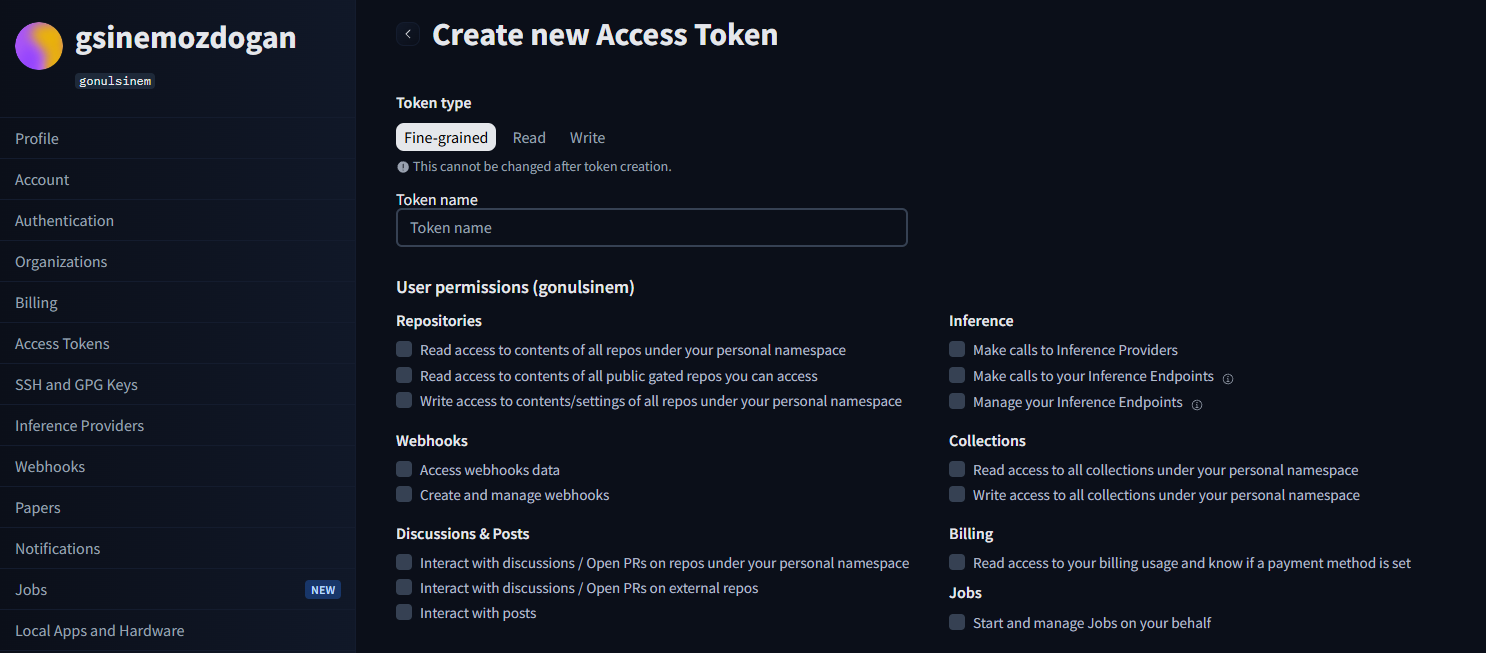

istenilen modeli seçip, gerekli izinleri alıp, transformers kısmından kullanabiliriz
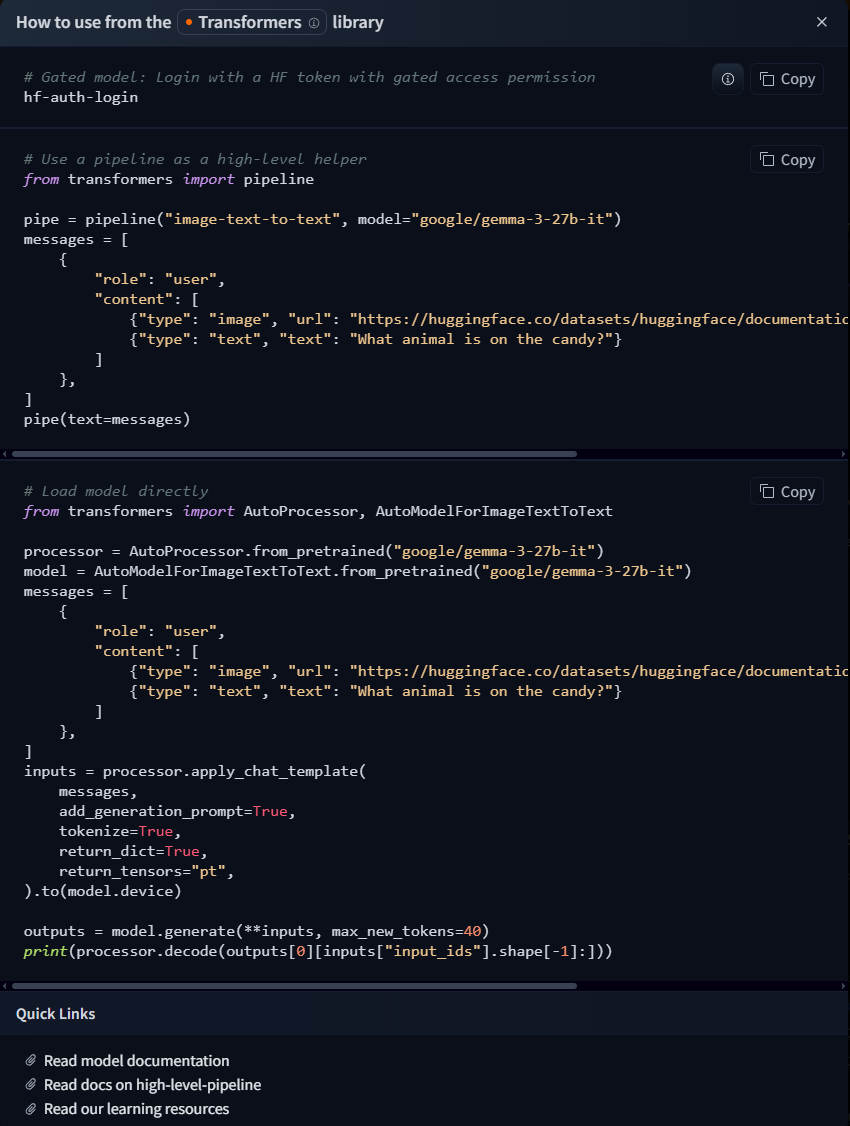

In [ ]:
from huggingface_hub import login

login(token="hf_XXXXXXXXXXXXXX")

In [14]:
from transformers import AutoProcessor

In [16]:
hf_tokenizer = AutoProcessor.from_pretrained("google/gemma-3-27b-it")

In [17]:
print(hf_tokenizer.tokenizer.vocab_size) #modelin vocab büyüklüğü 

262144


In [22]:
print(text1)
gemma_ids = hf_tokenizer.tokenizer.encode(text1) #metni token ID'lerine dönüştürme
print("Gemma Token IDs:", gemma_ids)
gemma_text = hf_tokenizer.tokenizer.decode(gemma_ids) #token ID'lerini tekrar metne dönüştürme
print("Decoded Gemma Text:", gemma_text)
print(gemma_text[5:])

The mother woke the child.
Gemma Token IDs: [2, 818, 5946, 50962, 506, 1919, 236761]
Decoded Gemma Text: <bos>The mother woke the child.
The mother woke the child.


In [26]:
hf_tokenizer.tokenizer.save_vocabulary("gemma_tokenizer_json") #vocab kaydetme

('gemma_tokenizer_json\\tokenizer.model',)

In [30]:
hf_tokenizer.tokenizer.get_vocab() #gemma modelinin vocab'ını döndürür

{'▁preferências': 226941,
 '▁peas': 38913,
 'ಜ': 238077,
 '▁branch': 9911,
 'rost': 22362,
 '▁crater': 81275,
 '▁Omphalodes': 194553,
 '座位': 165601,
 '▁сек': 78576,
 '▁광': 61541,
 '▁Winslow': 193506,
 '▁Kupp': 218746,
 '▁abstractions': 174547,
 'يفي': 227783,
 '▁negativos': 138796,
 '▁管': 167497,
 '▁separable': 82155,
 'ewomen': 193575,
 '▁preciso': 64501,
 '現實': 218890,
 '▁severe': 12778,
 'bner': 155756,
 'ෙක්': 166964,
 '▁share': 4024,
 '▁dup': 44361,
 '▁slumped': 203925,
 'लिसा': 156431,
 '▁financière': 160481,
 '咶': 255734,
 '▁வருகின்றனர்': 109268,
 'ToPointer': 117603,
 'मित्र': 86240,
 'ują': 22405,
 'によると': 133614,
 '▁pow': 5983,
 '▁Transfer': 26333,
 '▁розы': 231773,
 '▁Ná': 108644,
 '▁Pontiac': 166049,
 "='": 2507,
 '<unused4143>': 260045,
 '->': 1160,
 'Honey': 60538,
 'inius': 138299,
 '壕': 247526,
 '▁জানায়': 198576,
 '▁مزد': 215568,
 'UTICAL': 232292,
 '▁vou': 19414,
 '▁meandering': 189272,
 'c': 236755,
 '碁': 246029,
 'Zip': 45104,
 '▁Semantic': 154550,
 '<unused944>': 2

In [32]:
import json
with open("gemma_json_file.json", "w", encoding="utf-8") as f:
    json.dump(hf_tokenizer.tokenizer.get_vocab(), f)
# gemma sözlüğündeki kelimeler json dosyasına kaydedilir

In [ ]:
#aynı şekilde kendi oluşturduğumuz vocab'ları da json dosyasına kaydedebiliriz
basic_tokenizer_vocab = {k: v for k, v in vocab.items() if k != "</unk>"}
with open("basic_tokenizer_vocab_json.json", "w") as f:
    json.dump(basic_tokenizer_vocab, f) 

Oluşturulan vocab:
